In [2]:
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

  Attempting uninstall: fsspec

   --------- ------------------------------  3/13 [fsspec]
    Found existing installation: fsspec 2025.5.1
   --------- ------------------------------  3/13 [fsspec]
    Uninstalling fsspec-2025.5.1:
   --------- ------------------------------  3/13 [fsspec]
      Successfully uninstalled fsspec-2025.5.1
   --------- ------------------------------  3/13 [fsspec]
   --------- ------------------------------  3/13 [fsspec]
   --------- ------------------------------  3/13 [fsspec]
   --------- ------------------------------  3/13 [fsspec]
   --------- ------------------------------  3/13 [fsspec]
   --------------- ------------------------  5/13 [dill]
   --------------- ------------------------  5/13 [dill]
   --------------------- ------------------  7/13 [yarl]
   ------------------------ ---------------  8/13 [multiprocess]
   ------------------------ ---------------  8/13 [multi

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:

from datasets import load_dataset
from tqdm import tqdm
#downloads the dataset
ds = load_dataset("priyank-m/MJSynth_text_recognition", split="train")

# how progress while converting to list
samples = []
for sample in tqdm(ds, desc="Loading samples"):
    samples.append(sample)


C:\Users\joman\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading samples:  10%|█████▏                                                | 699871/7224600 [02:32<23:45, 4578.17it/s]


OSError: image file is truncated (29 bytes not processed)

In [7]:
from datasets import load_dataset
from tqdm import tqdm

# Load full dataset (will reuse cached version if already downloaded)
ds = load_dataset("priyank-m/MJSynth_text_recognition", split="train")

# Initialize an empty list to hold the first 60,000 samples
subset_samples = []

# Wrap tqdm around the loop to show a progress bar
for i, sample in enumerate(tqdm(ds, total=60000, desc="Loading 60,000 samples")):
    if i >= 60000:
        break
    subset_samples.append(sample)

# Now `subset_samples` contains the first 60,000 items
print(f"\n✅ Loaded {len(subset_samples)} samples from MJSynth.")


Loading 60,000 samples: 100%|██████████████████████████████████████████████████| 60000/60000 [00:23<00:00, 2560.18it/s]



✅ Loaded 60000 samples from MJSynth.


In [10]:
print(ds.features)


{'image': Image(mode=None, decode=True, id=None), 'label': Value(dtype='string', id=None)}


In [11]:
from datasets import load_dataset
import os
import string

# Constants
CHARS = string.ascii_lowercase + string.digits
DATA_DIR = "mjsynth_subset"
os.makedirs(DATA_DIR, exist_ok=True)

# Load dataset
ds = load_dataset("priyank-m/MJSynth_text_recognition", split="train")

# Save 60,000 filtered samples
count = 0
for i in range(len(ds)):
    label = ds[i]["label"].lower()
    if all(c in CHARS for c in label):  # filter out labels with unsupported characters
        image = ds[i]["image"]
        img_name = f"{label}_{i}.jpg"
        image.save(os.path.join(DATA_DIR, img_name))
        count += 1
        if count == 60000:
            break

print("✅ Successfully saved 60,000 images to:", DATA_DIR)


✅ Successfully saved 60,000 images to: mjsynth_subset


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import string

# ================= Constants =================
CHARS = string.ascii_lowercase + string.digits
char_to_idx = {c: i for i, c in enumerate(CHARS)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
NUM_CLASSES = len(CHARS) + 1  # +1 for CTC blank
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============= MJSynth Dataset =============
class MJSynthDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 100)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.samples = []
        for img_name in os.listdir(root_dir):
            if img_name.endswith(('.jpg', '.png')):
                label = img_name.split('_')[0].lower()
                if all(c in char_to_idx for c in label):
                    self.samples.append((img_name, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, word = self.samples[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        label = torch.tensor([char_to_idx[c] for c in word], dtype=torch.long)
        return image, label

# ============= CRNN Model =============
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1))
        )
        self.rnn = nn.LSTM(256 * 2, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(b, w, c * h)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.permute(1, 0, 2)

# ============= Utils =============
def collate_fn(batch):
    images, labels = zip(*batch)
    image_batch = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels)
    return image_batch, labels_concat, label_lengths

def decode(logits):
    probs = torch.softmax(logits, dim=2)
    _, preds = probs.max(2)
    preds = preds.permute(1, 0)
    results = []
    for pred in preds:
        string = ''
        last = -1
        for p in pred:
            p = p.item()
            if p != last and p != len(CHARS):
                string += idx_to_char[p]
            last = p
        results.append(string)
    return results

# ============= Evaluation =============
def evaluate_model(model, dataloader, max_samples=10, return_metrics=False):
    model.eval()
    correct_words = 0
    correct_chars = 0
    total_chars = 0

    with torch.no_grad():
        count = 0
        for images, labels, label_lengths in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = decode(outputs)

            label_idx = 0
            actuals = []
            for length in label_lengths:
                actual = ''.join([idx_to_char[labels[i].item()] for i in range(label_idx, label_idx + length)])
                actuals.append(actual)
                label_idx += length

            for pred, actual in zip(preds, actuals):
                if count < max_samples:
                    print(f"[{count+1}] Predicted: {pred} | Actual: {actual}")
                if pred == actual:
                    correct_words += 1
                correct_chars += sum(p == a for p, a in zip(pred, actual))
                total_chars += len(actual)
                count += 1

    total = len(dataloader.dataset)
    word_acc = 100 * correct_words / total
    char_acc = 100 * correct_chars / total_chars if total_chars > 0 else 0
    print(f"\n Word Accuracy: {word_acc:.2f}%")
    print(f" Character Accuracy: {char_acc:.2f}%")

    if return_metrics:
        return word_acc, char_acc


# ============= Training =============
import matplotlib.pyplot as plt  # Add at the top

def train_model():
    dataset = MJSynthDataset("./mjsynth_subset")
    train_size = int(0.8 * len(dataset))  # Changed from 0.9 to 0.8 to have more validation data
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    model = CRNN().to(DEVICE)
    criterion = nn.CTCLoss(blank=len(CHARS))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store metrics
    epoch_losses = []
    epoch_word_accuracies = []
    epoch_char_accuracies = []
    val_losses = []  # New list for validation losses

    for epoch in range(20):
        model.train()
        total_loss = 0
        for images, labels, label_lengths in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            output_len = torch.full((images.size(0), outputs.size(0), dtype=torch.long).to(DEVICE)

            optimizer.zero_grad()
            loss = criterion(outputs, labels, output_len, label_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"\n📚 Epoch {epoch + 1}: Loss = {avg_loss:.4f}")

        # Evaluate on training set
        train_word_acc, train_char_acc = evaluate_model(model, train_loader, return_metrics=True)
        epoch_word_accuracies.append(train_word_acc)
        epoch_char_accuracies.append(train_char_acc)

        # Calculate validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels, label_lengths in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                output_len = torch.full((images.size(0), outputs.size(0), dtype=torch.long).to(DEVICE)
                loss = criterion(outputs, labels, output_len, label_lengths)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), "crnn_model.pth")
    print("\n Model saved as crnn_model.pth")

    # Return metrics including validation losses
    return epoch_losses, epoch_word_accuracies, epoch_char_accuracies, val_losses

# Run the training
if __name__ == "__main__":
    losses, word_accs, char_accs, val_losses = train_model()

# ============= Run =============
if __name__ == "__main__":
    train_model()
    losses, word_accs, char_accs = train_model()




📚 Epoch 1: Loss = 3.0592
[1] Predicted: ss | Actual: slenderize
[2] Predicted:  | Actual: carla
[3] Predicted: sos | Actual: bishops
[4] Predicted:  | Actual: headbutting
[5] Predicted:  | Actual: romanesque
[6] Predicted: s | Actual: chipmunks
[7] Predicted: ed | Actual: waterlily
[8] Predicted: s | Actual: whoops
[9] Predicted: s | Actual: precis
[10] Predicted:  | Actual: babbler

 Word Accuracy: 0.00%
 Character Accuracy: 1.88%

📚 Epoch 2: Loss = 1.1646
[1] Predicted: slenderze | Actual: slenderize
[2] Predicted: garla | Actual: carla
[3] Predicted: bishops | Actual: bishops
[4] Predicted: eadeuttng | Actual: headbutting
[5] Predicted: ronanesoue | Actual: romanesque
[6] Predicted: cmpmunks | Actual: chipmunks
[7] Predicted: wacerlly | Actual: waterlily
[8] Predicted: whoops | Actual: whoops
[9] Predicted: precis | Actual: precis
[10] Predicted: bbbler | Actual: babbler

 Word Accuracy: 41.33%
 Character Accuracy: 63.97%

📚 Epoch 3: Loss = 0.6386
[1] Predicted: slenderze | Actual:

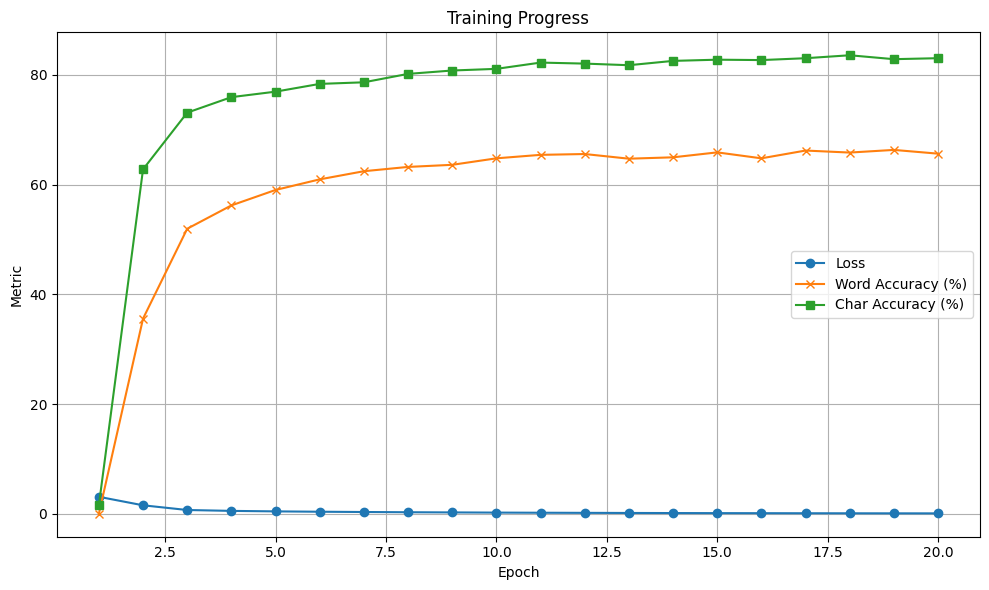

In [9]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Loss", marker='o')
plt.plot(epochs, word_accs, label="Word Accuracy (%)", marker='x')
plt.plot(epochs, char_accs, label="Char Accuracy (%)", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
#code to create a per-class chart
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import defaultdict
import numpy as np

# Assuming you have:
# - model already loaded and on DEVICE
# - dataset: your test or train dataset
# - CHARS and NUM_CLASSES defined

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
model.eval()

# Initialize total probability accumulator
class_probs = torch.zeros(NUM_CLASSES, device=DEVICE)
total_steps = 0

with torch.no_grad():
    for images, _, _ in dataloader:
        images = images.to(DEVICE)
        outputs = model(images)  # [T, B, C]
        probs = F.softmax(outputs, dim=2)  # Probabilities over classes

        # Sum over time steps and batch
        class_probs += probs.sum(dim=(0, 1))  # Sum over T and B
        total_steps += probs.shape[0] * probs.shape[1]  # T * B

# Normalize to get average probability per class
class_probs /= total_steps
class_probs = class_probs.cpu().numpy()

# Map to class labels
labels = list(CHARS) + ['[blank]']

# Plot
plt.figure(figsize=(14, 6))
plt.bar(labels, class_probs, color='skyblue')
plt.title("Per-Class Probability Distribution")
plt.xlabel("Character Class")
plt.ylabel("Average Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'dataset' is not defined


📚 Epoch 1: Loss = 3.0923
[1] Predicted: s | Actual: knobbier
[2] Predicted: m | Actual: windburned
[3] Predicted: c | Actual: mauled
[4] Predicted:  | Actual: radical
[5] Predicted:  | Actual: eris
[6] Predicted: s | Actual: capillary
[7] Predicted: mes | Actual: mercerize
[8] Predicted: c | Actual: sequined
[9] Predicted: c | Actual: belched
[10] Predicted: s | Actual: swiz

 Word Accuracy: 0.00%
 Character Accuracy: 2.31%
Validation Loss: 2.7160

📚 Epoch 2: Loss = 1.4906
[1] Predicted: storefront | Actual: storefront
[2] Predicted: pllc | Actual: pllc
[3] Predicted: holoerarts | Actual: holographs
[4] Predicted: hyades | Actual: hyades
[5] Predicted: coe | Actual: code
[6] Predicted: ses | Actual: velars
[7] Predicted: churns | Actual: churns
[8] Predicted: kd | Actual: kid
[9] Predicted: wronger | Actual: wronger
[10] Predicted: unicaton | Actual: unification

 Word Accuracy: 36.53%
 Character Accuracy: 59.40%
Validation Loss: 0.8578

📚 Epoch 3: Loss = 0.7153
[1] Predicted: uans | 

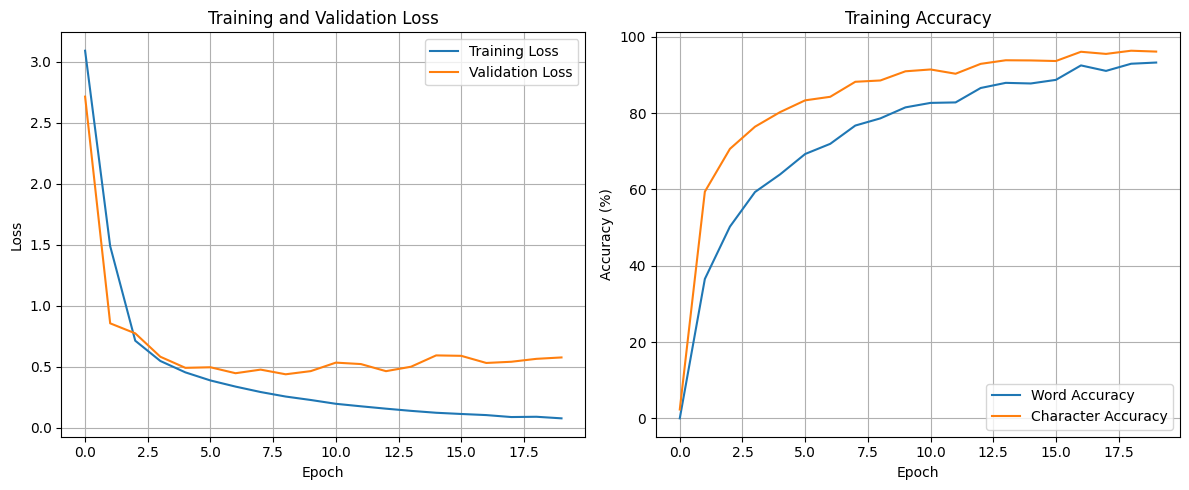

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import string
import matplotlib.pyplot as plt
import pickle

# ================= Constants =================
CHARS = string.ascii_lowercase + string.digits
char_to_idx = {c: i for i, c in enumerate(CHARS)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
NUM_CLASSES = len(CHARS) + 1  # +1 for CTC blank
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============= MJSynth Dataset =============
class MJSynthDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 100)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        self.samples = []
        for img_name in os.listdir(root_dir):
            if img_name.endswith(('.jpg', '.png')):
                label = img_name.split('_')[0].lower()
                if all(c in char_to_idx for c in label):
                    self.samples.append((img_name, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, word = self.samples[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        label = torch.tensor([char_to_idx[c] for c in word], dtype=torch.long)
        return image, label

# ============= CRNN Model =============
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1))
        )
        self.rnn = nn.LSTM(256 * 2, 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(b, w, c * h)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.permute(1, 0, 2)

# ============= Utils =============
def collate_fn(batch):
    images, labels = zip(*batch)
    image_batch = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels)
    return image_batch, labels_concat, label_lengths

def decode(logits):
    probs = torch.softmax(logits, dim=2)
    _, preds = probs.max(2)
    preds = preds.permute(1, 0)
    results = []
    for pred in preds:
        string = ''
        last = -1
        for p in pred:
            p = p.item()
            if p != last and p != len(CHARS):
                string += idx_to_char[p]
            last = p
        results.append(string)
    return results

# ============= Evaluation =============
def evaluate_model(model, dataloader, max_samples=10, return_metrics=False):
    model.eval()
    correct_words = 0
    correct_chars = 0
    total_chars = 0

    with torch.no_grad():
        count = 0
        for images, labels, label_lengths in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = decode(outputs)

            label_idx = 0
            actuals = []
            for length in label_lengths:
                actual = ''.join([idx_to_char[labels[i].item()] for i in range(label_idx, label_idx + length)])
                actuals.append(actual)
                label_idx += length

            for pred, actual in zip(preds, actuals):
                if count < max_samples:
                    print(f"[{count+1}] Predicted: {pred} | Actual: {actual}")
                if pred == actual:
                    correct_words += 1
                correct_chars += sum(p == a for p, a in zip(pred, actual))
                total_chars += len(actual)
                count += 1

    total = len(dataloader.dataset)
    word_acc = 100 * correct_words / total
    char_acc = 100 * correct_chars / total_chars if total_chars > 0 else 0
    print(f"\n Word Accuracy: {word_acc:.2f}%")
    print(f" Character Accuracy: {char_acc:.2f}%")

    if return_metrics:
        return word_acc, char_acc

# ============= Training =============
def train_model():
    dataset = MJSynthDataset("./mjsynth_subset")
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    model = CRNN().to(DEVICE)
    criterion = nn.CTCLoss(blank=len(CHARS))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store metrics
    epoch_losses = []
    epoch_word_accuracies = []
    epoch_char_accuracies = []
    val_losses = []

    for epoch in range(20):
        model.train()
        total_loss = 0
        for images, labels, label_lengths in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            output_len = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(DEVICE)

            optimizer.zero_grad()
            loss = criterion(outputs, labels, output_len, label_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"\n📚 Epoch {epoch + 1}: Loss = {avg_loss:.4f}")

        # Evaluate on training set
        train_word_acc, train_char_acc = evaluate_model(model, train_loader, return_metrics=True)
        epoch_word_accuracies.append(train_word_acc)
        epoch_char_accuracies.append(train_char_acc)

        # Calculate validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels, label_lengths in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                output_len = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(DEVICE)
                loss = criterion(outputs, labels, output_len, label_lengths)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), "crnn_model.pth")
    print("\n Model saved as crnn_model.pth")

    # Save metrics
    with open('training_metrics.pkl', 'wb') as f:
        pickle.dump({
            'train_loss': epoch_losses,
            'val_loss': val_losses,
            'word_acc': epoch_word_accuracies,
            'char_acc': epoch_char_accuracies
        }, f)

    return epoch_losses, epoch_word_accuracies, epoch_char_accuracies, val_losses

# ============= Run Training =============
if __name__ == "__main__":
    losses, word_accs, char_accs, val_losses = train_model()

    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(word_accs, label='Word Accuracy')
    plt.plot(char_accs, label='Character Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

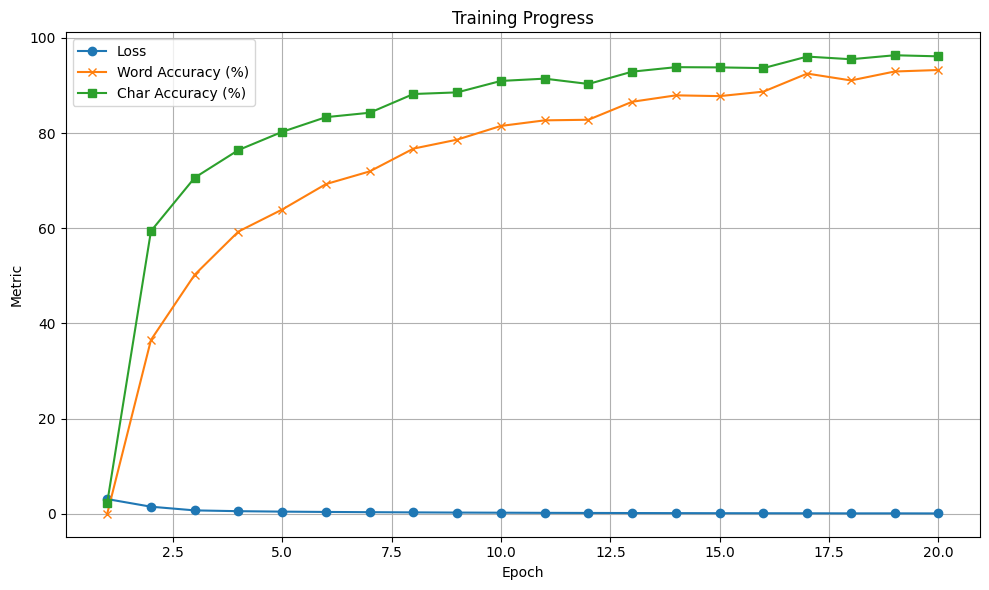

In [3]:

#Chart
import matplotlib.pyplot as plt

epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Loss", marker='o')
plt.plot(epochs, word_accs, label="Word Accuracy (%)", marker='x')
plt.plot(epochs, char_accs, label="Char Accuracy (%)", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

